<a href="https://colab.research.google.com/github/Dhrumillotiya03/Facial-Expression-Recognition/blob/main/Week-1/Linear_regression_Hubble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Data

The file opened below contains data of the line-of-sight velocities v/s the distance of several galaxies. Hubble's law says that these are linearly related. We try to do linear regression on the data to find a best fit line.
(The equation in line 2 is just conversion from distance-modulus form to raw distance in megaparsecs.)

Accuracy of instruments reduces substantially as the distance increases, so we only consider data points with  x<200  i.e. within 200 megaparsecs of Earth.

In [3]:
ogx,ogy=list(np.loadtxt("gdrive/My Drive/hubble.txt",unpack=True,skiprows=1,delimiter=","))
ogx = 10*(10**(ogx/5))/(10**6)

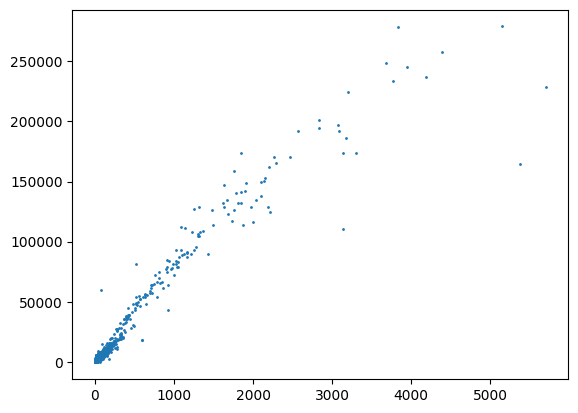

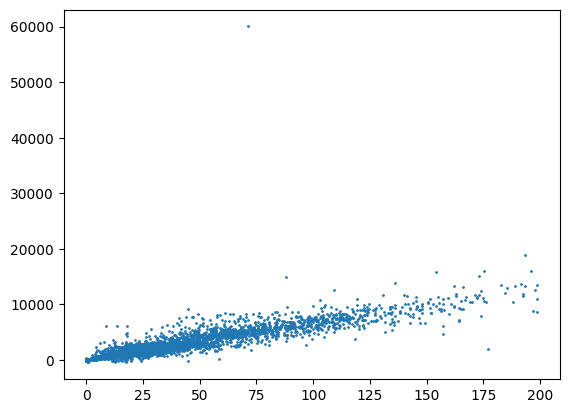

In [4]:
plt.scatter(ogx,ogy,s=1)
plt.show()
y_np = ogy[np.where(ogx<200)]
x_np = ogx[np.where(ogx<200)]
plt.scatter(x_np,y_np,s=1)
plt.show()

# **Linear Regression**

We first reshape the numpy arrays (currently in the form of list/row vector) to a column vector. We must not miss this step!

We also need to scale down the  y  vector values (here, by  10−4 ) to prevent the loss from blowing up to infinity.

Learning rate is also significantly reduced to prevent huge jumps in the parameter  w .

What momentum (call  m ) and dampening (call  d ) do : instead of setting gradient = gradient in current step, it sets gradient =  m× (gradient in previous step)  +   (1−d)× (gradient in current step)

# Stochastic Nature

MSE loss, in ideal case, takes the average of squared differences from all sample outputs. However, the PyTorch optimizer is designed to pick out a single randomly chosen sample point, and use it as MSE loss to calculate the gradient. This random choice of a point will give slightly different outputs each time the same code block is run.

epoch: 10, loss = 907.3238
epoch: 20, loss = 256.6649
epoch: 30, loss = 72.6160
epoch: 40, loss = 20.5555
epoch: 50, loss = 5.8295
epoch: 60, loss = 1.6641
epoch: 70, loss = 0.4859
epoch: 80, loss = 0.1526
epoch: 90, loss = 0.0583
epoch: 100, loss = 0.0317


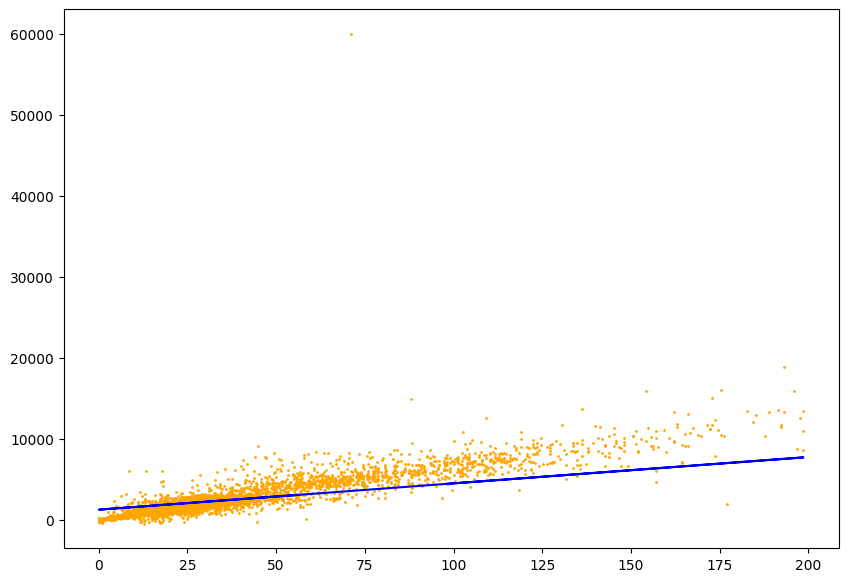

In [5]:
# 0) Prepare data
x_np = x_np.reshape(len(x_np),1)
y_np = y_np.reshape(len(y_np),1)

# cast to float Tensor
X = torch.from_numpy(x_np.astype(np.float32))
y = torch.from_numpy((1e-4*y_np).astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

# 1) Model
# Linear model f = wx + b
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 1e-5
p = 0.4

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = p, dampening = p)

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

# Plot
predicted = model(X).detach().numpy()

plt.figure(figsize=(10,7))
plt.scatter(x_np, y_np, color='orange',s=1)
plt.plot(x_np, 1e4*predicted, 'b')
plt.show()

# Initializing weights

A second source of randomness arises from the initialization of the weights - PyTorch does it on its own. However, in certain cases like the one above, we can provide a starting guess by visual inspection.

The code below implements a class LinearRegression that works exactly like nn.Linear() but allows us to initialize weights. A starting value of  30  for the slope seems to work well. We need to remember to scale it down by  10−4  too as we did for  y .

This gives us a slightly better linear fit. Again, due to the inherent randomness due to the earlier reason, we may need to run the cell a few times before getting a good enough fit.

epoch: 10, loss = 0.4291
epoch: 20, loss = 0.2995
epoch: 30, loss = 0.2607
epoch: 40, loss = 0.2490
epoch: 50, loss = 0.2455
epoch: 60, loss = 0.2444
epoch: 70, loss = 0.2441
epoch: 80, loss = 0.2439
epoch: 90, loss = 0.2439
epoch: 100, loss = 0.2438


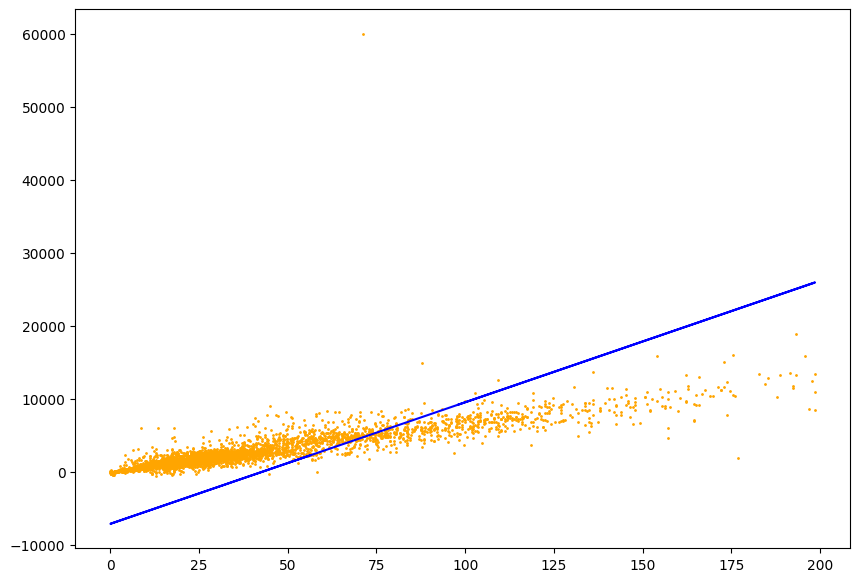

In [6]:
# 0) Prepare data
x_np = x_np.reshape(len(x_np),1)
y_np = y_np.reshape(len(y_np),1)

# cast to float Tensor
X = torch.from_numpy(x_np.astype(np.float32))
y = torch.from_numpy((1e-4*y_np).astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

# 1) Model
class LinearRegression(nn.Module):
    def __init__(self, weights):
        super(LinearRegression, self).__init__()

        self.linear = nn.Linear(weights.shape[1], weights.shape[0])
        with torch.no_grad():
            self.linear.weight.copy_(weights)

    def forward(self, x):
        x = self.linear(x)
        return x

weights = torch.tensor([[30*1e-4]])
model = LinearRegression(weights)


# Linear model f = wx + b
input_size = n_features
output_size = 1
#model = Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 1e-5
p = 0.4

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = p, dampening = p)

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

# Plot
predicted = model(X).detach().numpy()

plt.figure(figsize=(10,7))
plt.scatter(x_np, y_np, color='orange',s=1)
plt.plot(x_np, 1e4*predicted, 'b')
plt.show()